Make that we are running the correct version of TensorFlow first

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
import sys

assert sys.version_info >= (3, 6)  # Python ≥3.6 required
assert tf.__version__ >= "2.0"     # TensorFlow ≥2.0 required

# Dogs vs. Cats

The goal is to build a system to distinguish dogs vs. dogs.

This was a [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats) back in 2013. I will only use a subset of the available dataset here:
- 2,000 for training, split 50% dogs - 50% cats
- 1,000 for validation, split 50% dogs - 50% cats
- 1,000 for test, split 50% dogs - 50% cats

Here I will measure the accuracy of feature-extraction with a pretrained VGG16 model. I will also keep an eye for overfitting given the small size of the dataset.

In [3]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import matplotlib.pyplot as plt
%matplotlib inline

import random as rand

import numpy as np

import shutil

In [4]:
batch_size = 16

## Prepare the dataset

<font color='orange'>I manually downloaded the dataset from this [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats)</font>, unzipped it and here I will prepare for model training

In [5]:
data_path = Path("../data")
data_path.ls()

[PosixPath('../data/cache'),
 PosixPath('../data/preprocessed'),
 PosixPath('../data/.ipynb_checkpoints'),
 PosixPath('../data/raw')]

In [6]:
dogs_vs_cats_dir_name = "dogs-vs-cats"
raw_dir_name = "raw"
preprocessed_dir_name = "preprocessed"

train_dir_name = "train"
valid_dir_name = "valid"
test_dir_name = "test1"

dogs_dir_name = "dogs"
cats_dir_name = "cats"

raw_data_path = data_path/raw_dir_name/dogs_vs_cats_dir_name
preprocessed_data_path = data_path/preprocessed_dir_name/dogs_vs_cats_dir_name

dogs_train_data_path = preprocessed_data_path/train_dir_name/dogs_dir_name
cats_train_data_path = preprocessed_data_path/train_dir_name/cats_dir_name

dogs_valid_data_path = preprocessed_data_path/valid_dir_name/dogs_dir_name
cats_valid_data_path = preprocessed_data_path/valid_dir_name/cats_dir_name

dogs_test_data_path = preprocessed_data_path/test_dir_name/dogs_dir_name
cats_test_data_path = preprocessed_data_path/test_dir_name/cats_dir_name

In [7]:
raw_data_path.ls()

[PosixPath('../data/raw/dogs-vs-cats/test1'),
 PosixPath('../data/raw/dogs-vs-cats/train'),
 PosixPath('../data/raw/dogs-vs-cats/.ipynb_checkpoints')]

In [8]:
(raw_data_path/"train").ls()[:5]

[PosixPath('../data/raw/dogs-vs-cats/train/dog.8011.jpg'),
 PosixPath('../data/raw/dogs-vs-cats/train/cat.5077.jpg'),
 PosixPath('../data/raw/dogs-vs-cats/train/dog.7322.jpg'),
 PosixPath('../data/raw/dogs-vs-cats/train/cat.2718.jpg'),
 PosixPath('../data/raw/dogs-vs-cats/train/cat.10151.jpg')]

Create new directories

In [9]:
dogs_train_data_path.mkdir(parents=True, exist_ok=True)
cats_train_data_path.mkdir(parents=True, exist_ok=True)

dogs_valid_data_path.mkdir(parents=True, exist_ok=True)
cats_valid_data_path.mkdir(parents=True, exist_ok=True)

dogs_test_data_path.mkdir(parents=True, exist_ok=True)
cats_test_data_path.mkdir(parents=True, exist_ok=True)

Copy data over to preprocessed directory

In [10]:
raw_train_data_path = raw_data_path/"train"

def filter_files(key: str, path: Path): 
    return list(filter(lambda file_name: str(file_name).find(key) > 0, path.ls()))

dogs_files = filter_files("dog.", raw_train_data_path)
cats_files = filter_files("cat.", raw_train_data_path)
print(f"There are {len(dogs_files)} available dogs images, and {len(cats_files)} available cats images")

There are 12500 available dogs images, and 12500 available cats images


In [11]:
def copy(files: list, start_index: int, end_index: int, dest: Path):
    for i in range(start_index, end_index):
        shutil.copy(files[i], dest)

# Train
copy(dogs_files, 0, 1000, dogs_train_data_path)
copy(cats_files, 0, 1000, cats_train_data_path)

# Valid
copy(dogs_files, 1000, 1500, dogs_valid_data_path)
copy(cats_files, 1000, 1500, cats_valid_data_path)

# Test
copy(dogs_files, 1500, 2000, dogs_test_data_path)
copy(cats_files, 1500, 2000, cats_test_data_path)

## Explore the data

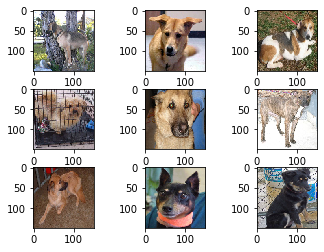

In [12]:
rows = 3
cols = 3

plt.subplots_adjust(wspace=0, hspace=.3)
for i, index in enumerate(rand.choices(range(len(dogs_files)), k=rows*cols), 1):
    plt.subplot(rows, cols, i)
    plt.imshow(load_img(dogs_files[index], target_size=(150, 150)))

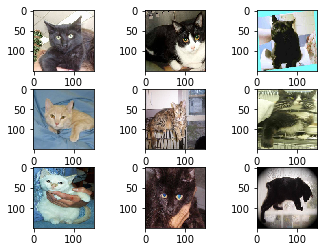

In [13]:
plt.subplots_adjust(wspace=0, hspace=.3)
for i, index in enumerate(rand.choices(range(len(dogs_files)), k=rows*cols), 1):
    plt.subplot(rows, cols, i)
    plt.imshow(load_img(cats_files[index], target_size=(150, 150)))

## Build data generators

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    str(preprocessed_data_path/train_dir_name),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = test_datagen.flow_from_directory(
    str(preprocessed_data_path/valid_dir_name),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    str(preprocessed_data_path/test_dir_name),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Check datagen outputs

In [15]:
image = load_img(dogs_files[0], target_size=(150, 150))
image_numpy = img_to_array(image)
x = image_numpy.reshape((1,) + image_numpy.shape)
x.shape

(1, 150, 150, 3)

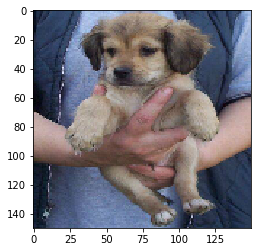

In [16]:
plt.imshow(image)

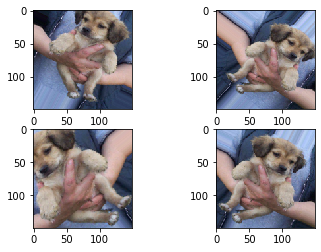

In [17]:
for i, batch in enumerate(train_datagen.flow(x, batch_size=1), 1):
    plt.subplot(2, 2, i)
    plt.imshow(array_to_img(batch[0]))
    
    if i == 4:
        break

## Train a basic ConvNet model

In [18]:
input_shape = train_generator[0][0].shape[1:]
input_shape

(150, 150, 3)

In [19]:
model = Sequential()

conv_base = VGG16(input_shape=input_shape,
                  include_top=False,
                  weights='imagenet')
conv_base.trainable = False
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


Check progress in TensorBoard by running `tensorboard --logdir=logs/dogs_vs_cats` in terminal

In [20]:
log_dir = '../logs/dogs_vs_cats'

# Clear logs from previous runs
!rm -r {log_dir}

callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

In [21]:
model.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
steps_per_epoch = len(train_generator)
validation_steps = len(valid_generator)

steps_per_epoch, validation_steps

(125, 63)

In [23]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    callbacks=callbacks,
    validation_data=valid_generator,
    validation_steps=validation_steps
)
history.history.keys()

Epoch 1/2
125/125 [==============================] - 583s 5s/step - loss: 0.6859 - accuracy: 0.5925 - val_loss: 0.4863 - val_accuracy: 0.8070
Epoch 2/2
125/125 [==============================] - 531s 4s/step - loss: 0.5682 - accuracy: 0.7045 - val_loss: 0.4094 - val_accuracy: 0.8320


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

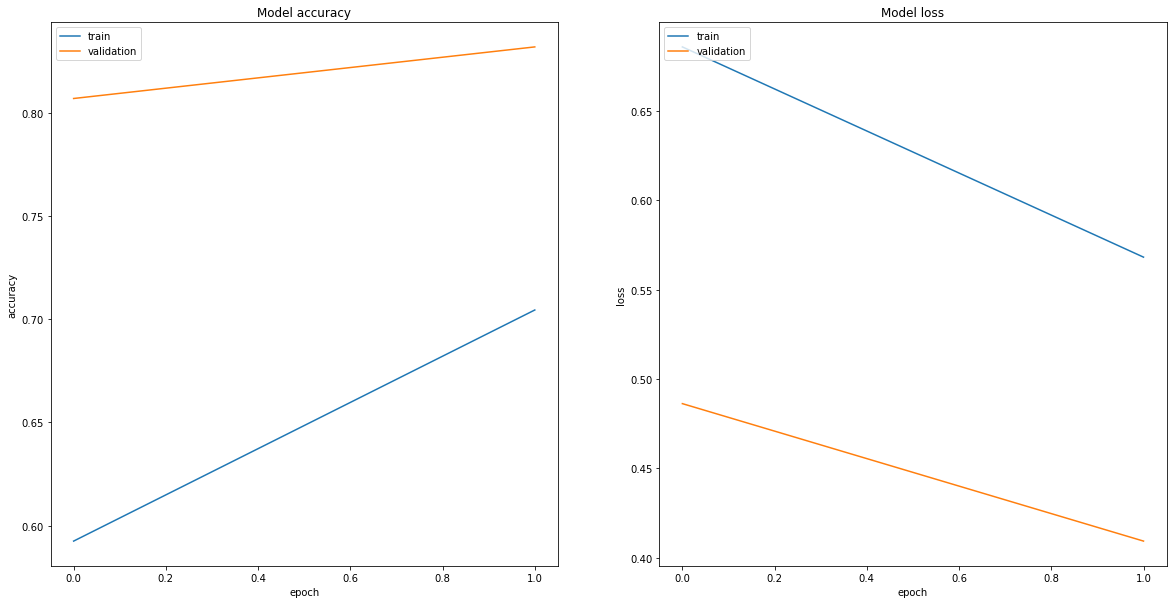

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

## Unfreeze some layers to fine-tune

In [25]:
conv_base.trainable = True

for layer in conv_base.layers:
    if layer.name.find("block5") >= 0:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [26]:
model.compile(optimizer=RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [28]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    callbacks=callbacks,
    validation_data=valid_generator,
    validation_steps=validation_steps
)
history.history.keys()

Epoch 1/100
125/125 [==============================] - 534s 4s/step - loss: 0.4456 - accuracy: 0.7870 - val_loss: 0.2752 - val_accuracy: 0.8760
Epoch 2/100
125/125 [==============================] - 556s 4s/step - loss: 0.3772 - accuracy: 0.8270 - val_loss: 0.2502 - val_accuracy: 0.8930
Epoch 3/100
  3/125 [..............................] - ETA: 7:58 - loss: 0.3323 - accuracy: 0.8750

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

## Save the model

In [ ]:
weights_path = Path("../weights")
weights_path.mkdir(parents=True, exist_ok=True)

In [ ]:
model.save(str(weights_path/"dogs_vs_cats_v4.h5"))

## Evaluate

Load the saved model

In [ ]:
model = keras.models.load_model(str(weights_path/"dogs_vs_cats_v4.h5"))

In [ ]:
model.trainable = False

# Compile model so changes to trainable would take effect
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
steps = len(test_generator)

loss, accuracy = model.evaluate_generator(
    test_generator,
    steps=steps
)
loss, accuracy